In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

## Load the data

In [ ]:
# Download the dataset
PATH_TO_DATA = 'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'
data = pd.read_csv(PATH_TO_DATA, header=None)
print(data.shape)
data.head()

(4998, 141)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,...,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.406388,-0.327528,-0.460868,-0.402536,-0.345752,-0.354206,-0.439959,-0.425326,-0.439789,-0.451835,-0.395926,-0.448762,-0.391789,-0.376307,-0.461069,-0.253524,0.213006,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,-0.298107,-0.428928,-0.491351,-0.361304,-0.339296,-0.324952,-0.290113,-0.363051,-0.525684,-0.597423,-0.575523,-0.567503,-0.504555,-0.618406,-0.682814,-0.743849,-0.815588,-0.826902,-0.782374,-0.929462,-0.999672,-1.060969,-1.007877,-1.028735,-1.122629,-1.028650,-1.046515,-1.063372,-1.122423,-0.983242,...,1.155363,1.336254,1.627534,1.717594,1.696487,1.741686,1.674078,1.546928,1.331738,1.110168,0.922210,0.521777,0.154852,-0.123861,-0.202998,-0.247956,-0.219122,-0.214695,-0.319215,-0.198597,-0.151618,-0.129593,-0.074939,-0.

## Split the data for training and testing

In [ ]:
# last column is the target
# 0 = anomaly, 1 = normal
TARGET = 140

features = data.drop(TARGET, axis=1)
target = data[TARGET]

x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, stratify=target
)

In [ ]:
# use case is novelty detection so use only the normal data
# for training
train_index = y_train[y_train == 1].index
train_data = x_train.loc[train_index]

## Scale the data using MinMaxScaler

In [ ]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(train_data.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

## Build an AutoEncoder model

In [ ]:
# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units

  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=8):
    super().__init__()
    self.encoder = Sequential([
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])

  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)

Epoch 1/20
5/5 [==============================] - 1s 52ms/step - loss: 0.0110 - mse: 0.0244 - val_loss: 0.0136 - val_mse: 0.0320
Epoch 2/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0106 - mse: 0.0235 - val_loss: 0.0134 - val_mse: 0.0314
Epoch 3/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0102 - mse: 0.0226 - val_loss: 0.0131 - val_mse: 0.0306
Epoch 4/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0095 - mse: 0.0211 - val_loss: 0.0128 - val_mse: 0.0300
Epoch 5/20
5/5 [==============================] - 0s 18ms/step - loss: 0.0088 - mse: 0.0194 - val_loss: 0.0125 - val_mse: 0.0293
Epoch 6/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0080 - mse: 0.0177 - val_loss: 0.0122 - val_mse: 0.0286
Epoch 7/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0072 - mse: 0.0159 - val_loss: 0.0119 - val_mse: 0.0279
Epoch 8/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0065 - mse: 0.0144 - val

## Plot history

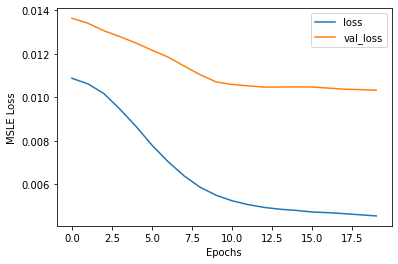

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

## Find threshold

In [ ]:
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)

  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def find_threshold_method_two(model, x_train_scaled):
  # another method to find threshold
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)

  threshold_2 = np.percentile(reconstruction_errors, 95)
  return threshold_2

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 0 = anomaly, 1 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
  return preds

In [ ]:
threshold = find_threshold(model, x_train_scaled)
print(f"Threshold method one: {threshold}")

threshold_2 = find_threshold_method_two(model, x_train_scaled)
print(f"Threshold method two: {threshold_2}")

Threshold method one: 0.01001314025746261
Threshold method two: 0.014635060198344029


In [ ]:
preds = get_predictions(model, x_test_scaled, threshold)
accuracy_score(preds, y_test)

0.944

## Tuning AutoEncoder using keras tuner



In [ ]:
!pip install -U keras-tuner

Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.7/dist-packages (1.0.2)


In [ ]:
import kerastuner as kt

class AutoEncoderTuner(Model):

  def __init__(self, hp, output_units, code_size=8):
    super().__init__()
    dense_1_units = hp.Int('dense_1_units', min_value=16, max_value=72, step=4)
    dense_2_units = hp.Int('dense_2_units', min_value=16, max_value=72, step=4)
    dense_3_units = hp.Int('dense_3_units', min_value=16, max_value=72, step=4)
    dense_4_units = hp.Int('dense_4_units', min_value=16, max_value=72, step=4)
    dense_5_units = hp.Int('dense_5_units', min_value=16, max_value=72, step=4)
    dense_6_units = hp.Int('dense_6_units', min_value=16, max_value=72, step=4)

    self.encoder = Sequential([
      Dense(dense_1_units, activation='relu'),
      Dropout(0.1),
      Dense(dense_2_units, activation='relu'),
      Dropout(0.1),
      Dense(dense_3_units, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(dense_4_units, activation='relu'),
      Dropout(0.1),
      Dense(dense_5_units, activation='relu'),
      Dropout(0.1),
      Dense(dense_6_units, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])

  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded


def build_model(hp):
  model = AutoEncoderTuner(hp, 140)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(
      loss='msle',
      optimizer=Adam(learning_rate=hp_learning_rate),
  )
  return model

In [ ]:
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='autoencoder',
    project_name='tuning_autoencoder6'
)

tuner.search(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)

INFO:tensorflow:Reloading Oracle from existing project autoencoder/tuning_autoencoder6/oracle.json
INFO:tensorflow:Reloading Tuner from autoencoder/tuning_autoencoder6/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [ ]:
hparams = [f'dense_{i}_units' for i in range(1,7)] + ['learning_rate']
best_hyperparams = tuner.get_best_hyperparameters()
for hps in hparams:
  print(f"{hps}: {best_hyperparams[0][hps]}")

dense_1_units: 40
dense_2_units: 32
dense_3_units: 16
dense_4_units: 44
dense_5_units: 36
dense_6_units: 36
learning_rate: 0.01


In [ ]:
best_model = tuner.get_best_models()[0]
best_model.compile(loss='msle', optimizer=Adam(0.001))

best_model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)

Epoch 1/20
5/5 [==============================] - 1s 52ms/step - loss: 0.0058 - val_loss: 0.0108
Epoch 2/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0052 - val_loss: 0.0105
Epoch 3/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0048 - val_loss: 0.0103
Epoch 4/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0046 - val_loss: 0.0101
Epoch 5/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0044 - val_loss: 0.0099
Epoch 6/20
5/5 [==============================] - 0s 18ms/step - loss: 0.0043 - val_loss: 0.0098
Epoch 7/20
5/5 [==============================] - 0s 18ms/step - loss: 0.0041 - val_loss: 0.0098
Epoch 8/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0040 - val_loss: 0.0097
Epoch 9/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0040 - val_loss: 0.0097
Epoch 10/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0038 - val_loss: 0.0096
Epoch 11/20
5/5 [============

In [ ]:
threshold_ = find_threshold(best_model, x_train_scaled)
preds_ = get_predictions(best_model, x_test_scaled, threshold_)
accuracy_score(preds_, y_test)

0.946